In [26]:
import requests
import re
import random
import pandas as pd
import nltk
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

books = ["https://www.gutenberg.org/cache/epub/1342/pg1342.txt",
         "https://www.gutenberg.org/cache/epub/11/pg11.txt",
         "https://www.gutenberg.org/cache/epub/2701/pg2701.txt",
         "https://www.gutenberg.org/cache/epub/345/pg345.txt",
         "https://www.gutenberg.org/cache/epub/84/pg84.txt",
         "https://www.gutenberg.org/cache/epub/1661/pg1661.txt"]
message = "everything is ok"
master_segments = []
master_labels = []


def getPartitions(books):
    for index, url in enumerate(books):
        response = requests.get(url)
        text = response.text
        max = len(text.split()) // 30 - 1
        if (max < 200):
            message = "The book " + chr(index) + " is too short"
            return message
        tokenized_sents = nltk.sent_tokenize(text)
        tokenized_word = nltk.word_tokenize(text)
        filtered_sents = []
        for w in tokenized_word:  #is this wrong and should be tokenized_word?
            if w.lower() not in stop_words:
                filtered_sents.append(w)
        authors = ['Jane Austen', 'Lewis Carroll', 'Herman Melville', 'Bram Stoker', 'Mary Wollstonecraft Shelley', 'Arthur Conan Doyle']        
        lable = authors[index]
        label_list = [lable] * 200
        starters = random.sample(range(0, max + 1), 200)
        segments = [" ".join(filtered_sents[i:i + 30]) for i in starters]
        master_segments.extend(segments)
        master_labels.extend(label_list)
        df = pd.DataFrame({"segment": master_segments, "label": master_labels})
    return df


nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
bookPertitions = getPartitions(books)
if isinstance(bookPertitions, str):
    print(bookPertitions)
else:
    print(bookPertitions.tail(10))
print(message)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/linshupei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                segment               label
1190  help cases . honour address ? ” “ may address ...  Arthur Conan Doyle
1191  note ? ” asked deep harsh voice strongly marke...  Arthur Conan Doyle
1192  “ Well , found plans seriously menaced . looke...  Arthur Conan Doyle
1193  nothing half dozen people neighbourhood least ...  Arthur Conan Doyle
1194  mask showing face . comes , mistaken , resolve...  Arthur Conan Doyle
1195  asked . “ Oh , turned men ’ heads part . daint...  Arthur Conan Doyle
1196  upon stairs passage , paused immediately outsi...  Arthur Conan Doyle
1197  instrument , crack one high-power lenses , wou...  Arthur Conan Doyle
1198  , instead theories suit facts . note . deduce ...  Arthur Conan Doyle
1199  . listened tell , began walk near Briony Lodge...  Arthur Conan Doyle
everything is ok


In [27]:
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import time 

segment_train, segment_test, label_train, label_test = train_test_split(bookPertitions['segment'],
                                                                        bookPertitions['label'], test_size=0.3,
                                                                        random_state=42)
vectorizer = CountVectorizer()
segment_train_bow = vectorizer.fit_transform(segment_train)
segment_test_bow = vectorizer.transform(segment_test)

model = MultinomialNB()

start_time = time.time()
model.fit(segment_train_bow, label_train)
end_time = time.time()

training_time_nb = end_time - start_time
print(f"Naive Bayes Training Time: {training_time_nb} seconds")

start_time = time.time()
predictions = model.predict(segment_test_bow)
end_time = time.time()

inference_time_nb = end_time - start_time
print(f"Naive Bayes Inference Time: {inference_time_nb} seconds")

accuracy = accuracy_score(label_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(label_test, predictions))


Naive Bayes Training Time: 0.004379987716674805 seconds
Naive Bayes Inference Time: 0.0014188289642333984 seconds
Accuracy: 0.95

Classification Report:
                             precision    recall  f1-score   support

         Arthur Conan Doyle       0.93      0.95      0.94        55
                Bram Stoker       0.97      0.95      0.96        59
            Herman Melville       0.95      0.91      0.93        57
                Jane Austen       1.00      0.93      0.96        59
              Lewis Carroll       0.90      1.00      0.95        69
Mary Wollstonecraft Shelley       0.98      0.95      0.97        61

                   accuracy                           0.95       360
                  macro avg       0.95      0.95      0.95       360
               weighted avg       0.95      0.95      0.95       360



In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(segment_train_bow, label_train)

predictions = rf_model.predict(segment_test_bow)

# Evaluate the model
accuracy = accuracy_score(label_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(label_test, predictions))


Accuracy: 0.90

Classification Report:
                             precision    recall  f1-score   support

         Arthur Conan Doyle       0.91      0.91      0.91        55
                Bram Stoker       0.89      0.83      0.86        59
            Herman Melville       0.73      0.95      0.82        57
                Jane Austen       0.96      0.85      0.90        59
              Lewis Carroll       0.99      0.97      0.98        69
Mary Wollstonecraft Shelley       0.95      0.87      0.91        61

                   accuracy                           0.90       360
                  macro avg       0.90      0.90      0.90       360
               weighted avg       0.91      0.90      0.90       360



In [29]:
from sklearn.neighbors import KNeighborsClassifier

# Create and train the k-NN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (k) based on your preference
knn_model.fit(segment_train_bow, label_train)

# Make predictions on the test set
predictions = knn_model.predict(segment_test_bow)

# Evaluate the model
accuracy = accuracy_score(label_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(label_test, predictions))


Accuracy: 0.59

Classification Report:
                             precision    recall  f1-score   support

         Arthur Conan Doyle       0.28      0.98      0.43        55
                Bram Stoker       0.92      0.41      0.56        59
            Herman Melville       0.80      0.21      0.33        57
                Jane Austen       1.00      0.41      0.58        59
              Lewis Carroll       0.96      0.97      0.96        69
Mary Wollstonecraft Shelley       1.00      0.51      0.67        61

                   accuracy                           0.59       360
                  macro avg       0.83      0.58      0.59       360
               weighted avg       0.84      0.59      0.61       360



In [30]:
from sklearn import svm

svm_model = svm.SVC(kernel='linear', C=20.0)

start_time = time.time()
svm_model.fit(segment_train_bow, label_train)
end_time = time.time()

training_time_svm = end_time - start_time
print(f"SVM Training Time: {training_time_svm} seconds")

# Make predictions on the test set
start_time = time.time()
predictions = svm_model.predict(segment_test_bow)
end_time = time.time()

inference_time_svm = end_time - start_time
print(f"SVM Inference Time: {inference_time_svm} seconds")

# Evaluate the model
accuracy = accuracy_score(label_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(label_test, predictions))


SVM Training Time: 0.2536470890045166 seconds
SVM Inference Time: 0.055459022521972656 seconds
Accuracy: 0.95

Classification Report:
                             precision    recall  f1-score   support

         Arthur Conan Doyle       0.91      0.93      0.92        55
                Bram Stoker       0.87      0.92      0.89        59
            Herman Melville       0.95      0.95      0.95        57
                Jane Austen       1.00      0.93      0.96        59
              Lewis Carroll       0.99      0.99      0.99        69
Mary Wollstonecraft Shelley       0.97      0.97      0.97        61

                   accuracy                           0.95       360
                  macro avg       0.95      0.95      0.95       360
               weighted avg       0.95      0.95      0.95       360



In [31]:
from sklearn.linear_model import SGDClassifier

# Create and train the SGD classifier
sgd_model = SGDClassifier(loss='hinge', alpha=0.0001, max_iter=100, random_state=42)
sgd_model.fit(segment_train_bow, label_train)

# Make predictions on the test set
predictions = sgd_model.predict(segment_test_bow)

# Evaluate the model
accuracy = accuracy_score(label_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(label_test, predictions))

Accuracy: 0.92

Classification Report:
                             precision    recall  f1-score   support

         Arthur Conan Doyle       0.91      0.89      0.90        55
                Bram Stoker       0.90      0.90      0.90        59
            Herman Melville       0.91      0.91      0.91        57
                Jane Austen       1.00      0.90      0.95        59
              Lewis Carroll       0.92      0.99      0.95        69
Mary Wollstonecraft Shelley       0.90      0.93      0.92        61

                   accuracy                           0.92       360
                  macro avg       0.92      0.92      0.92       360
               weighted avg       0.92      0.92      0.92       360



In [32]:
from sklearn.model_selection import cross_val_score, KFold

# Combine training and testing data for cross-validation
all_segments = bookPertitions['segment']
all_labels = bookPertitions['label']
all_data_bow = vectorizer.transform(all_segments)

# Create a 10-fold cross-validation object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation for Naive Bayes
nb_model = MultinomialNB()
nb_scores = cross_val_score(nb_model, all_data_bow, all_labels, cv=kf)
print("Naive Bayes Cross-Validation Accuracy: {:.2f}".format(nb_scores.mean()))

# Perform cross-validation for Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf_model, all_data_bow, all_labels, cv=kf)
print("Random Forest Cross-Validation Accuracy: {:.2f}".format(rf_scores.mean()))

# Perform cross-validation for K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_scores = cross_val_score(knn_model, all_data_bow, all_labels, cv=kf)
print("K-Nearest Neighbors Cross-Validation Accuracy: {:.2f}".format(knn_scores.mean()))

# Perform cross-validation for Support Vector Machine
svm_model = svm.SVC(kernel='linear', C=20.0)
svm_scores = cross_val_score(svm_model, all_data_bow, all_labels, cv=kf)
print("Support Vector Machine Cross-Validation Accuracy: {:.2f}".format(svm_scores.mean()))

# Perform cross-validation for Stochastic Gradient Descent
sgd_model = SGDClassifier(loss='hinge', alpha=0.0001, max_iter=100, random_state=42)
sgd_scores = cross_val_score(sgd_model, all_data_bow, all_labels, cv=kf)
print("Stochastic Gradient Descent Cross-Validation Accuracy: {:.2f}".format(sgd_scores.mean()))



Naive Bayes Cross-Validation Accuracy: 0.96
Random Forest Cross-Validation Accuracy: 0.92
K-Nearest Neighbors Cross-Validation Accuracy: 0.79
Support Vector Machine Cross-Validation Accuracy: 0.96
Stochastic Gradient Descent Cross-Validation Accuracy: 0.94


Model: MultinomialNB


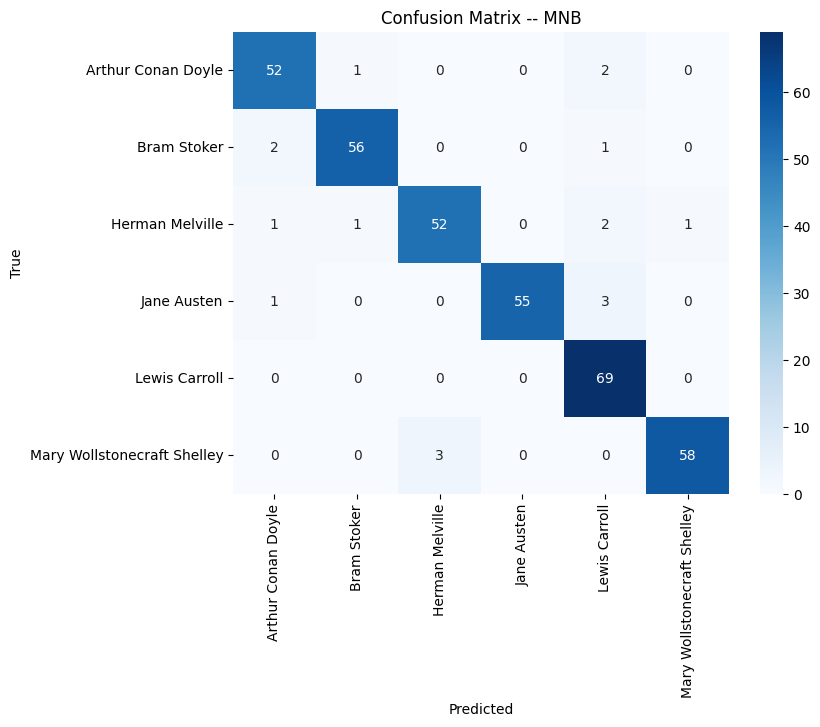

Misclassified Instances:
                                                Segment  \
1178  give away re-use terms Project Gutenberg Licen...   
570   world ever warm ; even Pale Sherry would rosy-...   
174   sarcastic humour , reserve , caprice , experie...   
636   colophon ] NEW YORK GROSSET & DUNLAP _Publishe...   
717   courteous bow , opened door octagonal room , e...   
597   deliriums death . Abominable tumblers pours po...   
433   , put shabby part whaling voyage , others set ...   
927   2 Chapter 3 Chapter 4 Chapter 5 Chapter 6 Chap...   
1024  look present . Majesty , course , stay London ...   
724   sort way . mumbled money sent letter , knew . ...   
497   visit Prairies June , scores scores miles wade...   
198   certainly hampered loosenesses construction , ...   
59    using eBook . Title : Pride Prejudice Author :...   
967   12 Chapter 13 Chapter 14 Chapter 15 Chapter 16...   
1169  eBook # 1661 ] recently updated : October 10 ,...   
914   3 Chapter 4 Chapter 5 Cha

In [34]:
#ERROR ANALYSIS FOR MultinomialNB model
from sklearn.metrics import confusion_matrix
import seaborn as sns
# List of models
models = [
    MultinomialNB(),
]

# Perform error analysis for each model
for model in models:
    # Train the model
    model.fit(segment_train_bow, label_train)
    
    # Make predictions on the test set
    predictions = model.predict(segment_test_bow)

    print(f"Model: {type(model).__name__}")

    # Generate confusion matrix
    conf_mat = confusion_matrix(label_test, predictions)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(label_test)),
                yticklabels=sorted(set(label_test)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix -- MNB')
    plt.show()

    # Display misclassified instances
    misclassified_indices = [i for i, (true_label, pred_label) in enumerate(zip(label_test, predictions)) if true_label != pred_label]
    misclassified_segments = segment_test.iloc[misclassified_indices]
    misclassified_labels = label_test.iloc[misclassified_indices]
    misclassified_predictions = predictions[misclassified_indices]

    # Display misclassified instances along with their true labels and predicted labels
    misclassified_df = pd.DataFrame({'Segment': misclassified_segments, 'True Label': misclassified_labels,
                                     'Predicted Label': misclassified_predictions})
    print("Misclassified Instances:")
    print(misclassified_df)


In [25]:
# Make predictions with MNB
predictions = model.predict(segment_test_bow)

#predict author function
def predict_author(paragraph, vectorizer, model):
    paragraph_bow = vectorizer.transform([paragraph])
    prediction = model.predict(paragraph_bow)
    return prediction[0]
paragraph_to_predict = "I cannot describe to you my sensations on the near prospect of my\
undertaking. It is impossible to communicate to you a conception of\
the trembling sensation, half pleasurable and half fearful, with which\
I am preparing to depart. I am going to unexplored regions, to “the\
land of mist and snow,” but I shall kill no albatross; therefore do not\
be alarmed for my safety or if I should come back to you as worn and\
woeful as the “Ancient Mariner.” You will smile at my allusion, but I\
will disclose a secret. I have often attributed my attachment to, my\
passionate enthusiasm for, the dangerous mysteries of ocean to that\
production of the most imaginative of modern poets."
predicted_author = predict_author(paragraph_to_predict, vectorizer, model)

print(f"Predicted author: {predicted_author}")

Predicted author: Mary Wollstonecraft Shelley


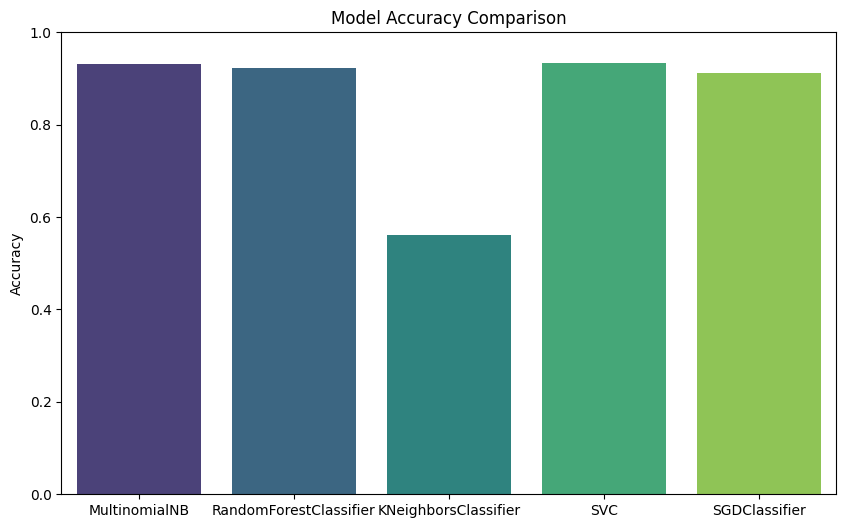

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# List of models
models = [MultinomialNB(), RandomForestClassifier(n_estimators=100, random_state=42),
          KNeighborsClassifier(n_neighbors=5), svm.SVC(kernel='linear', C=20.0),
          SGDClassifier(loss='hinge', alpha=0.0001, max_iter=100, random_state=42)]

# Lists to store model names and accuracies
model_names = []
accuracies = []

# Visualize accuracy for each model
for model in models:
    model.fit(segment_train_bow, label_train)
    predictions = model.predict(segment_test_bow)
    accuracy = accuracy_score(label_test, predictions)
    
    model_names.append(type(model).__name__)
    accuracies.append(accuracy)

# Bar chart for accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.ylim(0, 1.0)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()